# Face Classifier

ЧТО НУЖНО БУДЕТ СДЕЛАТЬ:

- Скачать и загрузить датасет (вы найдёте его здесь).
- Отрисовать один батч загруженных данных.
- Выбрать предобученную модель.
- Обучить многоклассовый классификатор, используя выбранную модель.
- Визуализировать предсказания модели.
- Описать полученные результаты в текстовой ячейке ноутбука.

In [1]:
!pip -q install pytorch_lightning

     |████████████████████████████████| 582 kB 5.0 MB/s 
     |████████████████████████████████| 408 kB 45.3 MB/s 
     |████████████████████████████████| 596 kB 17.7 MB/s 
     |████████████████████████████████| 136 kB 47.7 MB/s 
     |████████████████████████████████| 1.1 MB 29.4 MB/s 
     |████████████████████████████████| 271 kB 40.9 MB/s 
     |████████████████████████████████| 144 kB 47.6 MB/s 
     |████████████████████████████████| 94 kB 2.2 MB/s 


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torch.nn import functional as F

import torchvision
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

import pytorch_lightning as pl

import os
import random
from tqdm import tqdm
from copy import copy
from pathlib import Path

In [3]:
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext tensorboard

print(f'pl={pl.__version__}')
print(f'torch={torch.__version__}')
print(f'torchvision={torchvision.__version__}')

pl=1.6.1
torch=1.10.0+cu111
torchvision=0.11.1+cu111


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
!cp /content/gdrive/MyDrive/DATA/CV_project1_data.zip /content
!unzip -qq -d /content /content/CV_project1_data.zip
!ls /content

CV_project1_data.zip  data  gdrive  sample_data


In [7]:
!ls /content/data

train  valid


In [11]:
DATA_DIR = Path('/content/data')

BATCH_SIZE = 32
SEED = 20220421

In [21]:
train_dataset = ImageFolder(DATA_DIR / 'train')
valid_dataset = ImageFolder(DATA_DIR / 'valid')

print(len(train_dataset), len(valid_dataset))

3000 914


In [22]:
def plot_samples(dataset, num_samples: int):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))
    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")
    plt.show()

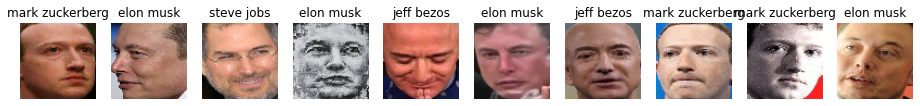

In [23]:
plot_samples(train_dataset, num_samples=10)

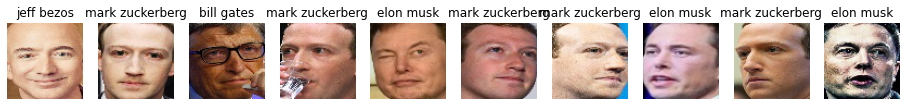

In [24]:
plot_samples(valid_dataset, num_samples=10)

In [31]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

train_dataset.transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.ToTensor(),
    normalize,
])

test_transformations = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(70),
    transforms.ToTensor(),
    normalize,
])

In [32]:
NUM_WORKERS = 4 # or os.cpu_count()

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [33]:
class FaceModel(pl.LightningModule):
    def __init__(self, num_classes: int):
        super().__init__()

        # используем предобученную модель ResNet-34
        self.net = models.resnet34(pretrained=True)
        # замораживаем веса
        for parameter in self.net.parameters():
            parameter.requres_grad = False
        # заменяем полносвязный слой на новый под нужное количество классов
        self.net.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_nb):
        images, target = batch
        output = self(images)
        # используем "функциональную" версию функции потерь вместо инстанцирования модуля
        loss = F.cross_entropy(output, target)
        with torch.no_grad():
            top1 = torch.mean((output.argmax(1) == target).float()).item()

        # логируем метрики — они будут как в прогрессбаре внизу, так и в отдельной директории
        self.log('loss/train', loss, on_step=False, on_epoch=True)
        self.log('top1/train', top1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, target = batch
        output = self(images)
        loss = loss = F.cross_entropy(output, target)
        top1 = torch.mean((output.argmax(1) == target).float()).item()

        self.log('loss/val', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('top1/val', top1, on_step=False, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.net.parameters(), lr=1e-2, weight_decay=1e-4)

In [34]:
model = FaceModel(num_classes=len(train_dataset.classes))

In [35]:
trainer = pl.Trainer(
    gpus=1, # amount of GPU we wanted to use
    max_epochs=30,
    progress_bar_refresh_rate=1,
)
trainer.fit(model, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /content/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | net  | ResNet | 21.3 M
--------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.149    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [37]:
def view_hist(hist):
    ohist = []
    ohist = [h.cpu().numpy() for h in hist]

    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,len(hist)+1),ohist,label="Pretrained")
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, len(hist)+1, 1.0))
    plt.legend()
    plt.show()

In [36]:
torch.save(model.state_dict(), "model.pt")

In [42]:
model.to(device)

FaceModel(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [44]:
from PIL import Image

test_path = DATA_DIR / 'valid/elon_musk'


class TestImageFolder:
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(self.root)
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_file = os.path.join(self.root, self.image_files[idx])
        return self.transform(Image.open(image_file)), self.image_files[idx]

In [45]:
from torch.utils.data import DataLoader

test_dataset = TestImageFolder(test_path, transform=test_transformations)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [46]:
predictions = []
labels = []
with torch.no_grad():
    for images, lbls in tqdm(test_dataloader):
        probs = model(images.to(device))
        predictions.extend(probs.argmax(-1).tolist())
        labels.extend(lbls)


100%|██████████| 4/4 [00:01<00:00,  3.31it/s]


In [49]:
idx_to_class = {i: c for c, i in train_dataset.class_to_idx.items()}

In [51]:
prediction_classes = []
for num in predictions:
    prediction_classes.append(idx_to_class[num])

In [52]:
df = pd.DataFrame({
    'Id': labels,
    'Label': prediction_classes,
})
df.head(10)

,Id,Label
0,e602a8f5-4b5c-4a07-82a0-f08d2ad1872c.jpg,elon_musk
1,c463baac-ae4f-4512-ba23-76fa4764db22.jpg,mark_zuckerberg
2,f425f81a-1e20-48a9-83f9-c675b4958490.jpg,elon_musk
3,d66df516-9ae7-4c67-98f1-47c1a4d0d94b.jpg,steve_jobs
4,e0bac848-e51b-41c5-8a49-1687d11810d5.jpg,mark_zuckerberg
5,f4ab37df-ae68-4525-abed-98d2c5616c1f.jpg,elon_musk
6,f2c0d79c-ab3f-4a36-b226-c54a78f49b94.jpg,jeff_bezos
7,f1ca4c5d-754b-4e35-8287-991788a2f368.jpg,jeff_bezos
8,ceee4b30-a474-4fe5-b743-82bca98ee647.jpg,elon_musk
9,cee200d6-b3a9-4411-b373-4e6ebed2b71e.jpg,elon_musk


In [73]:
def plot_result(df, num_samples: int):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))
    i = 0
    for _, x in df.sample(num_samples).iterrows():
        img = Image.open(test_path / x['Id'])
        axes[i].imshow(img)
        axes[i].set_title(x['Label'])
        axes[i].axis("off")
        i += 1
    plt.show()

Result of training model after 30 epochs:
`[loss=0.00544, loss/val=0.0394, top1/val=0.988, top1/train=1.000]`

Lets visualize 10 correctly classified images and 10 images where model was wrong

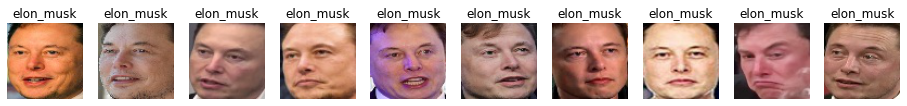

In [77]:
plot_result(df[df['Label'] == 'elon_musk'], num_samples=10)

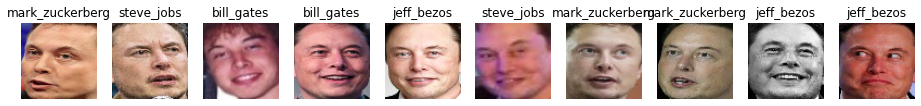

In [76]:
plot_result(df[df['Label'] != 'elon_musk'], num_samples=10)

In [78]:
df.groupby('Label').size()

Label
bill_gates         33
elon_musk          54
jeff_bezos         39
mark_zuckerberg    39
steve_jobs         29
dtype: int64

Let check how the model works with images from the internet.

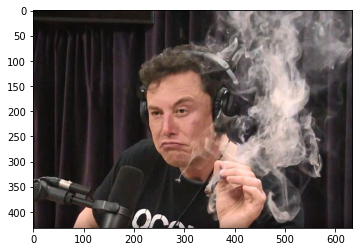

In [110]:
import requests

res = requests.get('https://i.dailymail.co.uk/i/newpix/2018/09/07/08/4FD1F62300000578-6142193-image-m-9_1536304932759.jpg', stream=True)
image = Image.open(res.raw)

plt.imshow(image)

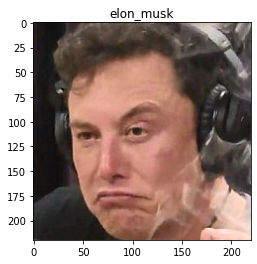

In [111]:
image = image.crop((190, 90, 410, 310)) # take a face region from the picture

x = test_transformations(image)
x = torch.unsqueeze(x, dim=0)

probs = model(x.to(device))
label_index = np.argmax(probs.tolist())

label = idx_to_class[label_index]

plt.title(label)
plt.imshow(image)